In [3]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Magic command to change plotting backend
#%matplotlib qt

# Magic command to load watermark
#%load_ext watermark

In [4]:
# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore') 

In [5]:
# load data
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

def load_matrices_simple(results_dir, n_rois=400):
    """
    Simple function to load and average connectivity matrices
    
    Parameters:
    results_dir (str): Directory containing connectivity matrices
    n_rois (int): Number of ROIs (200 or 400)
    
    Returns:
    tuple: (averaged_matrix, region_labels)
    """
    # Load all individual matrices
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_{n_rois}/*_connectivity_matrix.npy')
    #matrix_files = glob.glob(f'{results_dir}/connectivity_matrices/*_connectivity_matrix.npy')
    
    if not matrix_files:
        raise FileNotFoundError(f"No connectivity matrices found in {results_dir}/connectivity_matrices_{n_rois}/")
    
    print(f"Found {len(matrix_files)} connectivity matrices")
    
    # Load and average matrices
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    # Create simple region labels
    region_labels = [f"Region_{i+1}" for i in range(n_rois)]
    
    return matrix, region_labels


# Set up paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Create figures directory if it doesn't exist
#os.makedirs(f'{results_dir}/figures', exist_ok=True)

# Load 400 ROI data
matrix, region_labels = load_matrices_simple(results_dir, n_rois=400)

# Now you can proceed with the visualization functions

Found 19 connectivity matrices


In [ ]:
# heat map



Network after thresholding and removing self-loops:
Number of nodes: 400
Number of edges: 25

After removing isolated nodes:
Number of nodes remaining: 29
Number of edges: 25


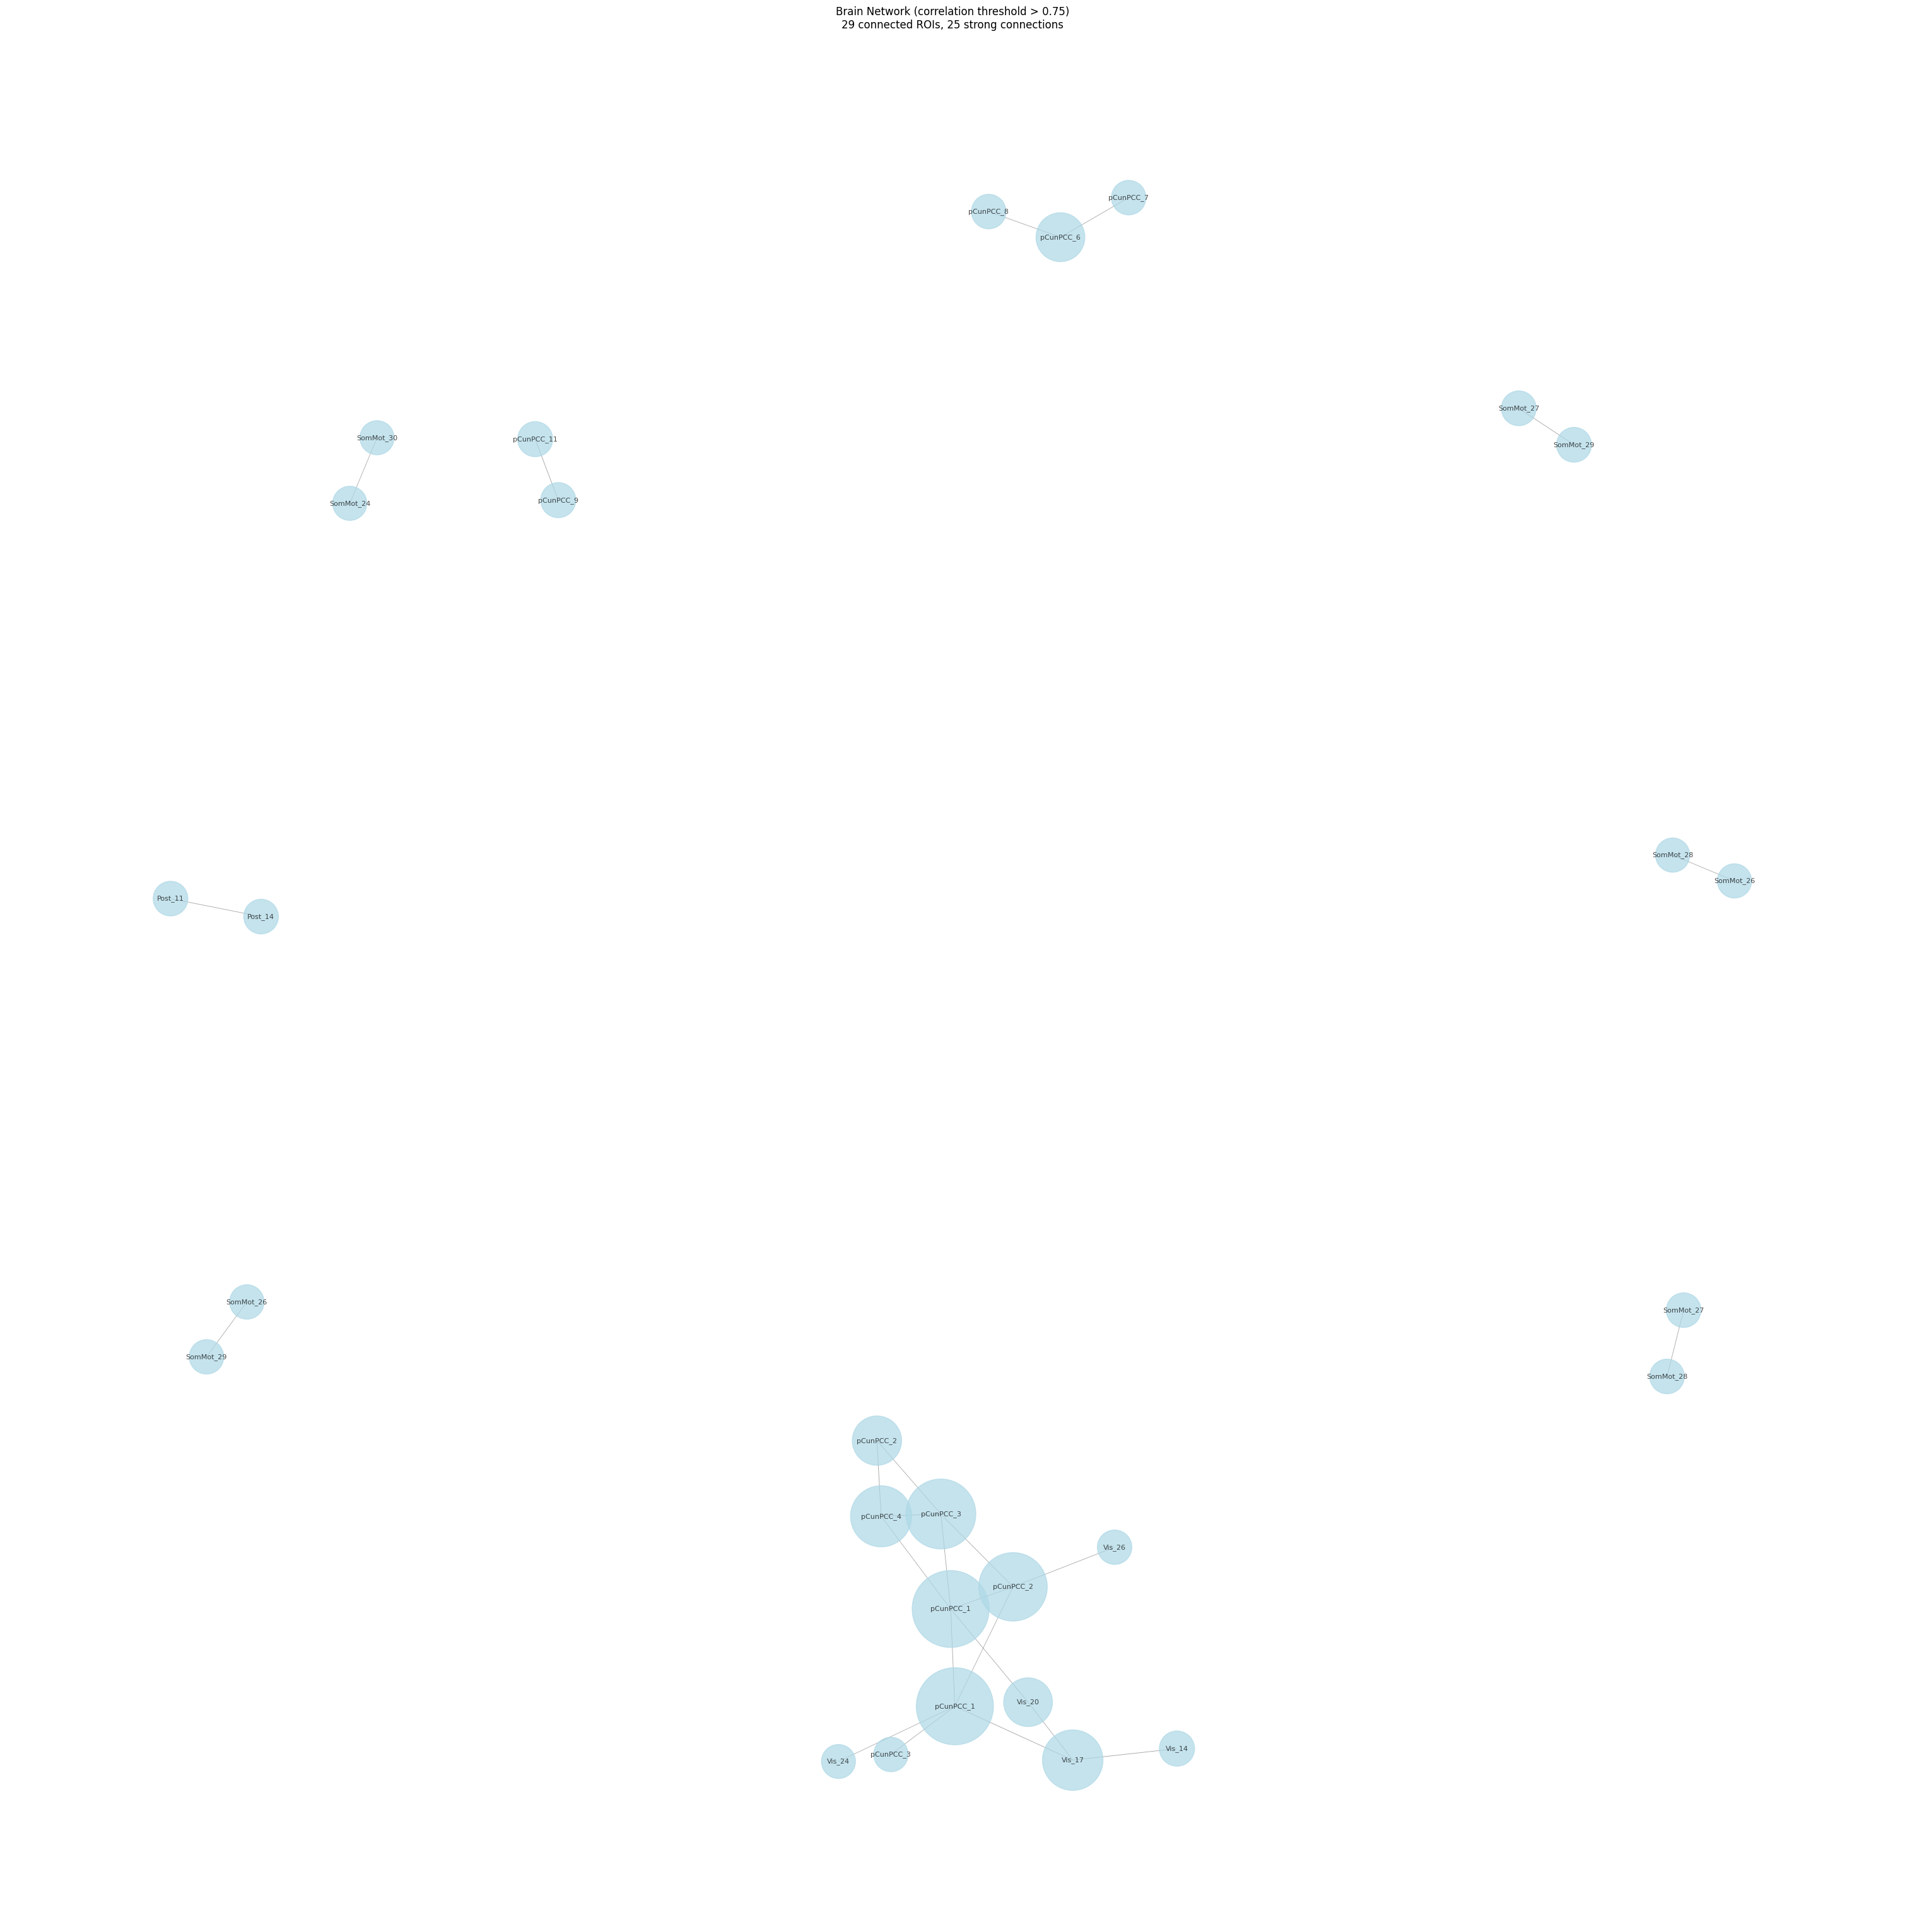

In [13]:
#graph theory analysis and visualization
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets

# Get Schaefer atlas and labels
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=2)
labels = schaefer_atlas.labels

# Clean up labels - remove the prefix and hemisphere info for clarity
clean_labels = [label.decode('utf-8').split('_')[-2] + '_' + label.decode('utf-8').split('_')[-1] 
                for label in labels]

# First create the thresholded matrix
matrix_thresholded = matrix.copy()
threshold = 0.75
matrix_thresholded[matrix_thresholded <= threshold] = 0

# Create graph from thresholded matrix
G = nx.from_numpy_array(matrix_thresholded)

# Remove self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))

print(f"Network after thresholding and removing self-loops:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Remove isolated nodes (nodes with no connections)
isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

print(f"\nAfter removing isolated nodes:")
print(f"Number of nodes remaining: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Create label dictionary for remaining nodes
node_labels = {node: clean_labels[node] for node in G.nodes()}

# Calculate normalized node strengths
strength = G.degree(weight='weight')
node_sizes = [val * 2000 for (node, val) in strength]  # Scale for visibility

# Set up the visualization
plt.figure(figsize=(30, 30))

# Calculate edge widths
edgewidth = [d['weight'] for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G, k=2/np.sqrt(G.number_of_nodes()), iterations=100)

# Draw network
nx.draw(G, pos, 
        with_labels=True, 
        width=np.power(edgewidth, 2),  # Square the edge widths
        edge_color='grey', 
        node_size=node_sizes,
        labels=node_labels,
        font_color='black', 
        node_color='lightblue',  # Can be modified based on your needs
        alpha=0.7, 
        font_size=8)

plt.title(f'Brain Network (correlation threshold > {threshold})\n'
          f'{G.number_of_nodes()} connected ROIs, {G.number_of_edges()} strong connections')

plt.show()

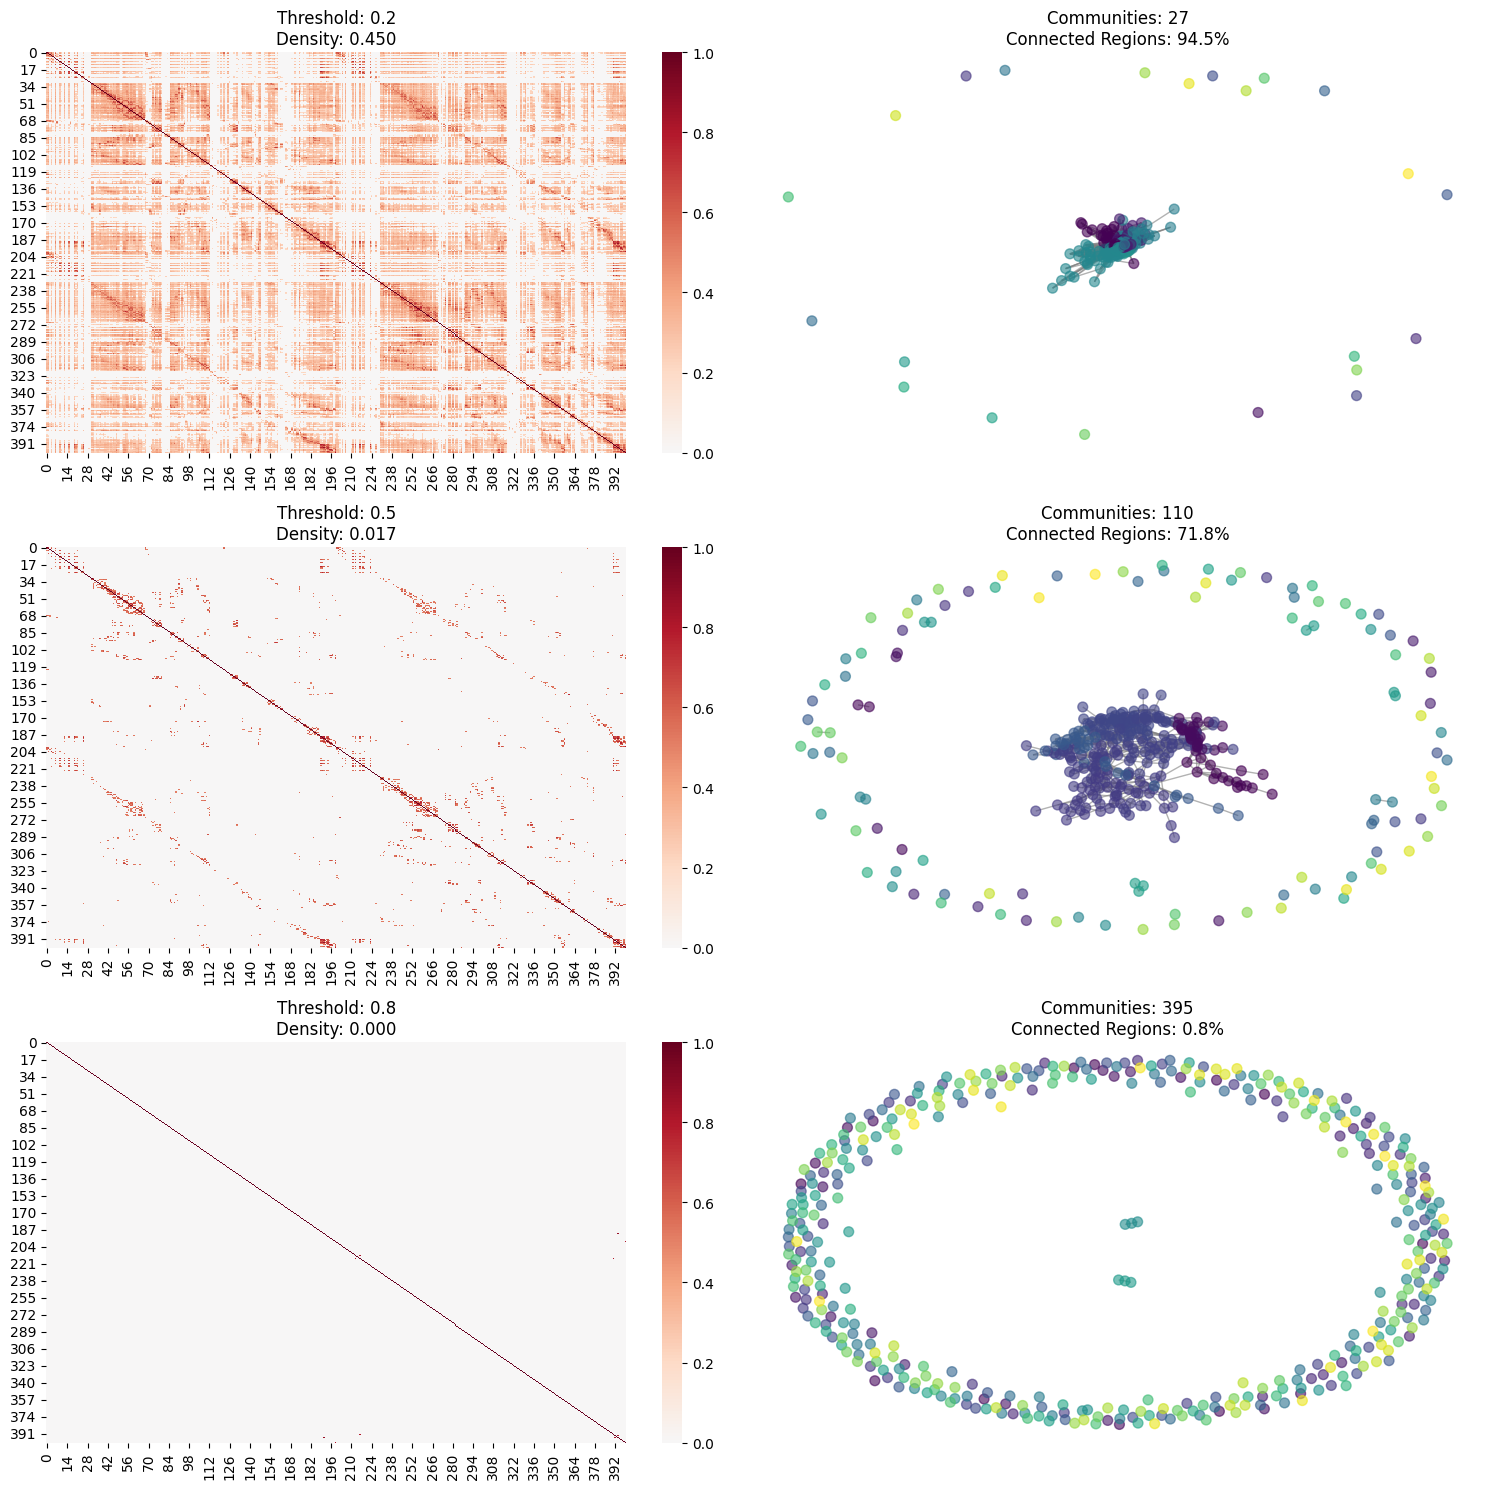


Summary of findings:
-------------------
Total brain regions analyzed: 400

What the thresholds tell us:

At threshold 0.2:
- Kept 45.5% of all possible connections
- Found 28 distinct brain communities
- 36096 strong connections between regions

At threshold 0.5:
- Kept 2.2% of all possible connections
- Found 113 distinct brain communities
- 1529 strong connections between regions

At threshold 0.8:
- Kept 0.5% of all possible connections
- Found 395 distinct brain communities
- 205 strong connections between regions


In [ ]:
# graph theory analysis and visualization
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import community
from nilearn import datasets

def analyze_brain_connectivity(matrix, labels, thresholds=[0.2, 0.5, 0.8]):
    """
    Analyze how different correlation thresholds affect brain network properties.
    
    Args:
        matrix: Correlation matrix of brain regions
        labels: Brain region labels
        thresholds: List of correlation thresholds to test
    """
    # Set up figure for our results
    fig, axes = plt.subplots(len(thresholds), 2, figsize=(15, 5*len(thresholds)))
    
    for idx, threshold in enumerate(thresholds):
        # Create thresholded matrix
        matrix_thresh = matrix.copy()
        matrix_thresh[matrix_thresh <= threshold] = 0
        
        # Create graph
        G = nx.from_numpy_array(matrix_thresh)
        G.remove_edges_from(list(nx.selfloop_edges(G)))
        
        # Calculate basic properties
        density = nx.density(G)
        communities = community.best_partition(G, weight='weight')
        n_communities = len(set(communities.values()))
        
        # Get largest connected group of brain regions
        largest_component = max(nx.connected_components(G), key=len)
        connectivity_ratio = len(largest_component) / G.number_of_nodes()
        
        # Plot correlation matrix
        sns.heatmap(matrix_thresh, ax=axes[idx, 0], cmap='RdBu_r', center=0)
        axes[idx, 0].set_title(f'Threshold: {threshold}\nDensity: {density:.3f}')
        
        # Plot network
        nx.draw(G, ax=axes[idx, 1], 
                node_color=list(communities.values()),
                node_size=50,
                edge_color='gray',
                alpha=0.6)
        axes[idx, 1].set_title(f'Communities: {n_communities}\nConnected Regions: {connectivity_ratio:.1%}')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nSummary of findings:")
    print("-------------------")
    print(f"Total brain regions analyzed: {len(labels)}")
    print("\nWhat the thresholds tell us:")
    for threshold in thresholds:
        matrix_thresh = matrix.copy()
        matrix_thresh[matrix_thresh <= threshold] = 0
        G = nx.from_numpy_array(matrix_thresh)
        density = nx.density(G)
        n_communities = len(set(community.best_partition(G, weight='weight').values()))
        print(f"\nAt threshold {threshold}:")
        print(f"- Kept {(density*100):.1f}% of all possible connections")
        print(f"- Found {n_communities} distinct brain communities")
        
        # Count strong connections
        strong_connections = np.sum(matrix_thresh > 0) / 2  # divide by 2 because matrix is symmetric
        print(f"- {strong_connections:.0f} strong connections between regions")

# Run the analysis
analyze_brain_connectivity(matrix, clean_labels)

In [ ]:
# largest brain networks
def analyze_communities(matrix, labels, threshold=0.5):
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[matrix_thresh <= threshold] = 0
    
    # Create graph and find communities
    G = nx.from_numpy_array(matrix_thresh)
    communities = community.best_partition(G, weight='weight')
    
    # Group regions by community
    community_regions = {}
    for node, comm_id in communities.items():
        if comm_id not in community_regions:
            community_regions[comm_id] = []
        community_regions[comm_id].append(labels[node])
    
    # Print largest communities
    print("Largest brain networks found:")
    for comm_id, regions in sorted(community_regions.items(), 
                                 key=lambda x: len(x[1]), 
                                 reverse=True)[:5]:
        print(f"\nNetwork {comm_id} ({len(regions)} regions):")
        print(", ".join(regions[:5]) + "..." if len(regions) > 5 else "")

# Run analysis
analyze_communities(matrix, clean_labels)

Largest brain networks found:

Network 20 (47 regions):
SomMot_2, SomMot_4, SomMot_5, SomMot_6, SomMot_7...

Network 22 (47 regions):
SomMot_16, SomMot_17, SomMot_19, SomMot_20, SomMot_22...

Network 21 (34 regions):
SomMot_15, SomMot_21, Post_5, Post_6, Post_7...

Network 3 (33 regions):
Vis_7, Vis_10, Vis_11, Vis_13, Vis_16...

Network 23 (30 regions):
SomMot_18, SomMot_23, SomMot_24, Post_15, Med_1...


In [ ]:
#brain network composition
def analyze_network_composition(matrix, labels, threshold=0.5):
    # Create thresholded matrix and find communities
    matrix_thresh = matrix.copy()
    matrix_thresh[matrix_thresh <= threshold] = 0
    G = nx.from_numpy_array(matrix_thresh)
    communities = community.best_partition(G, weight='weight')
    
    # Analyze composition of each community
    community_composition = {}
    for node, comm_id in communities.items():
        if comm_id not in community_composition:
            community_composition[comm_id] = {}
        
        # Get the network type (before the underscore)
        network_type = labels[node].split('_')[0]
        community_composition[comm_id][network_type] = community_composition[comm_id].get(network_type, 0) + 1
    
    # Print composition of largest communities
    print("Detailed composition of largest networks:")
    for comm_id in [20, 22, 21, 3, 23]:  # Our largest networks
        print(f"\nNetwork {comm_id} composition:")
        total = sum(community_composition[comm_id].values())
        for network, count in sorted(community_composition[comm_id].items(), key=lambda x: x[1], reverse=True):
            percentage = (count/total) * 100
            print(f"{network}: {count} regions ({percentage:.1f}%)")

# Run the analysis
analyze_network_composition(matrix, clean_labels)

Detailed composition of largest networks:

Network 20 composition:
SomMot: 19 regions (38.0%)
FrOperIns: 9 regions (18.0%)
Par: 5 regions (10.0%)
TempOccPar: 4 regions (8.0%)
Temp: 4 regions (8.0%)
PFC: 3 regions (6.0%)
ParOper: 2 regions (4.0%)
PFCv: 2 regions (4.0%)
Post: 1 regions (2.0%)
TempOcc: 1 regions (2.0%)

Network 22 composition:
Med: 11 regions (35.5%)
pCunPCC: 8 regions (25.8%)
SomMot: 7 regions (22.6%)
Post: 2 regions (6.5%)
Cing: 2 regions (6.5%)
pCun: 1 regions (3.2%)

Network 21 composition:
SomMot: 14 regions (43.8%)
PFCl: 5 regions (15.6%)
FEF: 4 regions (12.5%)
PrCv: 3 regions (9.4%)
Post: 2 regions (6.2%)
ParOper: 2 regions (6.2%)
PFC: 1 regions (3.1%)
PrC: 1 regions (3.1%)

Network 3 composition:
Vis: 19 regions (57.6%)
pCunPCC: 12 regions (36.4%)
pCun: 2 regions (6.1%)

Network 23 composition:
SomMot: 30 regions (69.8%)
Med: 4 regions (9.3%)
Post: 3 regions (7.0%)
FEF: 3 regions (7.0%)
PFC: 1 regions (2.3%)
PFCl: 1 regions (2.3%)
PFCdPFCm: 1 regions (2.3%)


In [ ]:
# community structure
def visualize_community_structure(matrix, labels, threshold=0.5):
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[matrix_thresh <= threshold] = 0
    
    # Create graph and find communities
    G = nx.from_numpy_array(matrix_thresh)
    communities = community.best_partition(G, weight='weight')
    
    # Create a summary of each community's size and main type
    community_summary = {}
    for node, comm_id in communities.items():
        if comm_id not in community_summary:
            community_summary[comm_id] = {'size': 0, 'types': {}}
        
        community_summary[comm_id]['size'] += 1
        node_type = labels[node].split('_')[0]
        community_summary[comm_id]['types'][node_type] = community_summary[comm_id]['types'].get(node_type, 0) + 1
    
    # Print summary sorted by size
    print("Community Structure at Threshold 0.5:")
    print("------------------------------------")
    for comm_id, info in sorted(community_summary.items(), key=lambda x: x[1]['size'], reverse=True):
        main_type = max(info['types'].items(), key=lambda x: x[1])[0]
        print(f"\nCommunity {comm_id}: {info['size']} nodes")
        print(f"Dominant type: {main_type} ({info['types'][main_type]} nodes)")
        if len(info['types']) > 1:
            print("Also contains:", ', '.join([f"{k} ({v})" for k, v in info['types'].items() if k != main_type]))

# Run the visualization
visualize_community_structure(matrix, clean_labels)

Community Structure at Threshold 0.5:
------------------------------------

Community 19: 59 nodes
Dominant type: SomMot (23 nodes)
Also contains: Post (1), ParOper (2), TempOcc (1), FrOperIns (13), Temp (10), Par (4), PFC (2), TempOccPar (2), PFCv (1)

Community 20: 45 nodes
Dominant type: SomMot (15 nodes)
Also contains: Post (13), PrCv (2), ParOper (2), Par (9), TempOccPar (2), PrC (1), PFCl (1)

Community 22: 45 nodes
Dominant type: PFCl (20 nodes)
Also contains: SomMot (1), FEF (6), PrCv (1), PFCmp (2), PFC (9), Med (2), PFCdPFCm (4)

Community 1: 35 nodes
Dominant type: Vis (21 nodes)
Also contains: pCunPCC (12), pCun (2)

Community 23: 35 nodes
Dominant type: SomMot (28 nodes)
Also contains: Med (2), Post (4), FEF (1)

Community 21: 31 nodes
Dominant type: Med (11 nodes)
Also contains: SomMot (7), Post (2), pCun (1), Cing (2), pCunPCC (8)

Community 0: 14 nodes
Dominant type: Vis (6 nodes)
Also contains: Post (3), TempPole (5)

Community 61: 12 nodes
Dominant type: PFC (6 nodes)


Top 10 connected nodes:

Left Hemisphere:
Node 78: Degree = 12, Strength = 7.47
Node 46: Degree = 12, Strength = 7.48
Node 190: Degree = 11, Strength = 7.66
Node 19: Degree = 12, Strength = 7.90
Node 85: Degree = 13, Strength = 7.94
Node 65: Degree = 13, Strength = 8.06
Node 55: Degree = 14, Strength = 8.32
Node 60: Degree = 14, Strength = 8.40
Node 49: Degree = 14, Strength = 8.63
Node 56: Degree = 17, Strength = 10.44

Right Hemisphere:
Node 63: Degree = 11, Strength = 6.96
Node 32: Degree = 12, Strength = 7.04
Node 194: Degree = 11, Strength = 7.23
Node 16: Degree = 11, Strength = 7.27
Node 82: Degree = 12, Strength = 7.63
Node 52: Degree = 13, Strength = 8.08
Node 191: Degree = 12, Strength = 8.27
Node 56: Degree = 13, Strength = 8.34
Node 58: Degree = 15, Strength = 9.17
Node 55: Degree = 15, Strength = 9.59


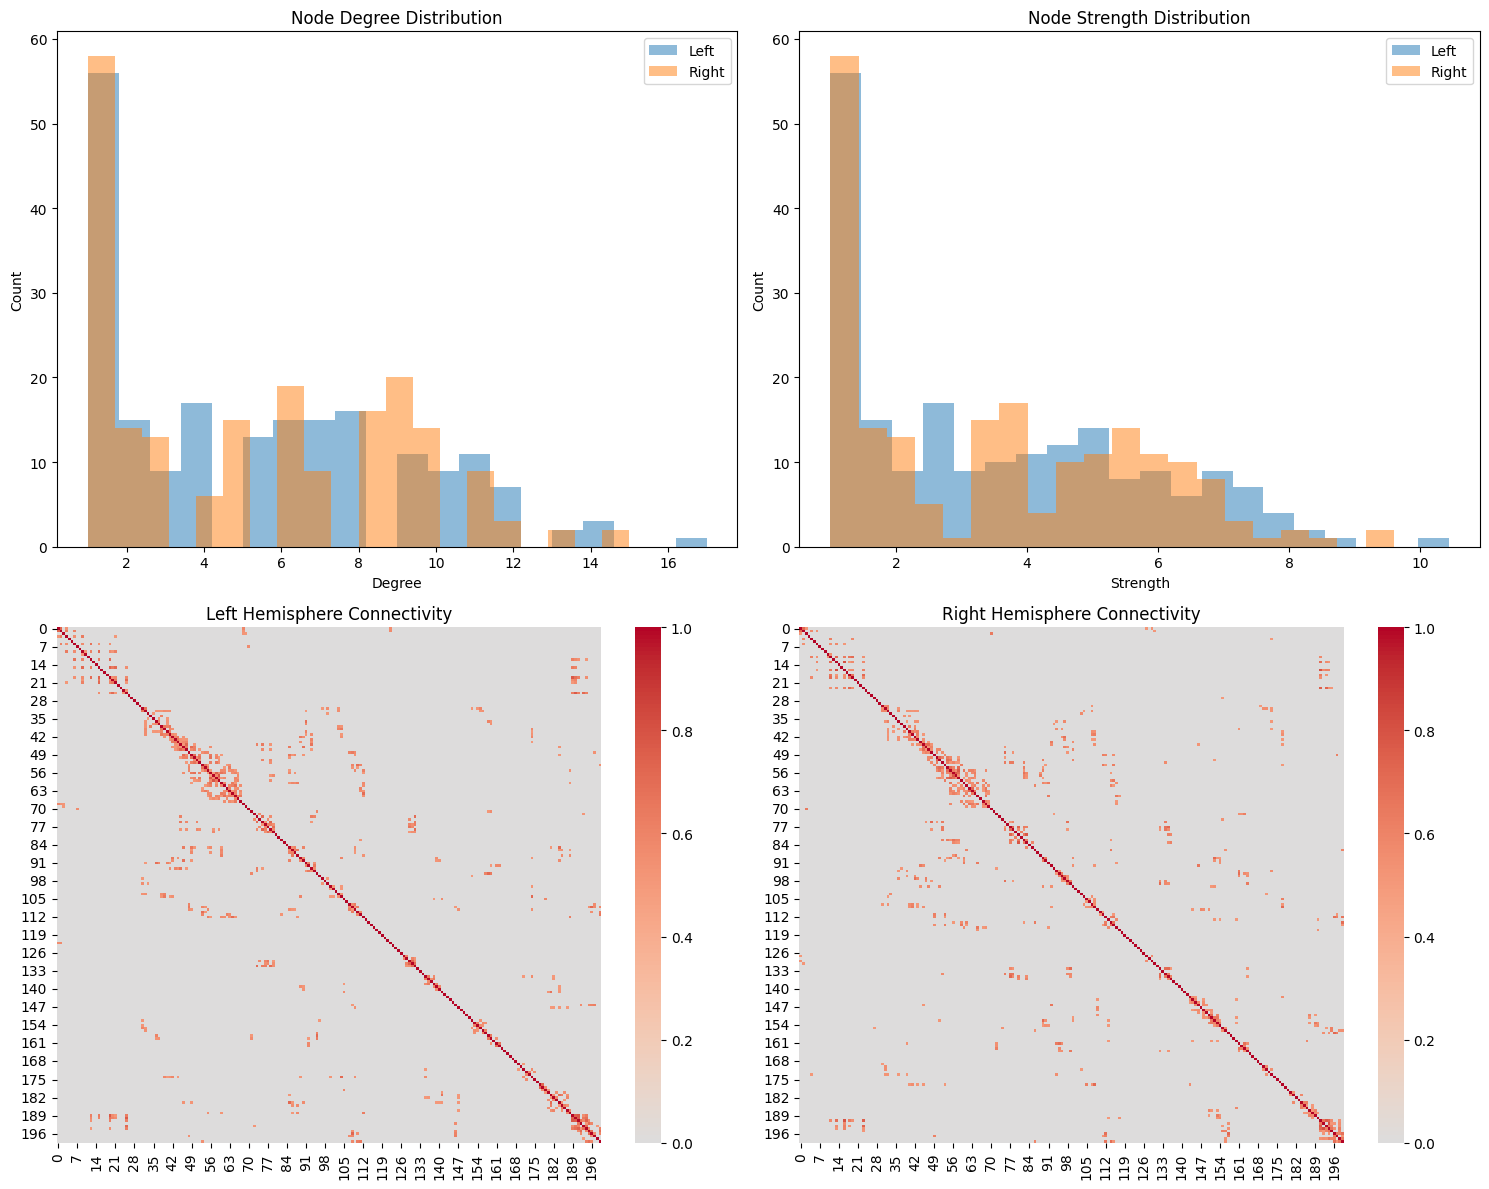

In [26]:
# hemisphereic brain network analysis
# 1. Individual Node Connectivity Analysis
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_node_connectivity(matrix, threshold=0.5):
    """
    Analyze individual node connectivity patterns in each hemisphere
    """
    # Split matrix into hemispheres (assuming first half is left, second half is right)
    n_regions = matrix.shape[0]
    mid_point = n_regions // 2
    
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[np.abs(matrix_thresh) <= threshold] = 0
    
    # Split into hemispheres
    left_matrix = matrix_thresh[:mid_point, :mid_point]
    right_matrix = matrix_thresh[mid_point:, mid_point:]
    
    # Calculate node degree and strength for each hemisphere
    def get_node_metrics(mat):
        # Number of connections (degree)
        degree = np.sum(mat != 0, axis=1)
        # Sum of connection weights (strength)
        strength = np.sum(np.abs(mat), axis=1)
        return degree, strength
    
    left_degree, left_strength = get_node_metrics(left_matrix)
    right_degree, right_strength = get_node_metrics(right_matrix)
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot degree distributions
    ax1.hist(left_degree, bins=20, alpha=0.5, label='Left')
    ax1.hist(right_degree, bins=20, alpha=0.5, label='Right')
    ax1.set_title('Node Degree Distribution')
    ax1.set_xlabel('Degree')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    # Plot strength distributions
    ax2.hist(left_strength, bins=20, alpha=0.5, label='Left')
    ax2.hist(right_strength, bins=20, alpha=0.5, label='Right')
    ax2.set_title('Node Strength Distribution')
    ax2.set_xlabel('Strength')
    ax2.set_ylabel('Count')
    ax2.legend()
    
    # Plot node-wise connectivity matrices
    sns.heatmap(left_matrix, ax=ax3, cmap='coolwarm', center=0)
    ax3.set_title('Left Hemisphere Connectivity')
    
    sns.heatmap(right_matrix, ax=ax4, cmap='coolwarm', center=0)
    ax4.set_title('Right Hemisphere Connectivity')
    
    plt.tight_layout()
    
    # Find highly connected nodes
    top_n = 10
    left_hubs = np.argsort(left_strength)[-top_n:]
    right_hubs = np.argsort(right_strength)[-top_n:]
    
    print(f"\nTop {top_n} connected nodes:")
    print("\nLeft Hemisphere:")
    for idx in left_hubs:
        print(f"Node {idx}: Degree = {left_degree[idx]}, Strength = {left_strength[idx]:.2f}")
    
    print(f"\nRight Hemisphere:")
    for idx in right_hubs:
        print(f"Node {idx}: Degree = {right_degree[idx]}, Strength = {right_strength[idx]:.2f}")
    
    return {
        'left': {'degree': left_degree, 'strength': left_strength},
        'right': {'degree': right_degree, 'strength': right_strength}
    }

# Run analysis
node_metrics = analyze_node_connectivity(matrix, threshold=0.5)


Top Hub Regions:

Degree Centrality:

Left Hemisphere:
Node 56: 0.090
Node 49: 0.075
Node 55: 0.075
Node 60: 0.075
Node 65: 0.070

Right Hemisphere:
Node 55: 0.080
Node 58: 0.080
Node 52: 0.070
Node 56: 0.070
Node 32: 0.065

Betweenness Centrality:

Left Hemisphere:
Node 109: 0.166
Node 174: 0.144
Node 108: 0.124
Node 195: 0.093
Node 40: 0.080

Right Hemisphere:
Node 177: 0.093
Node 173: 0.092
Node 53: 0.089
Node 4: 0.073
Node 43: 0.056

Closeness Centrality:

Left Hemisphere:
Node 109: 0.371
Node 174: 0.358
Node 49: 0.341
Node 55: 0.339
Node 85: 0.337

Right Hemisphere:
Node 177: 0.345
Node 53: 0.338
Node 43: 0.334
Node 45: 0.332
Node 41: 0.325

Eigenvector Centrality:

Left Hemisphere:
Node 56: 0.347
Node 60: 0.270
Node 49: 0.261
Node 65: 0.243
Node 58: 0.237

Right Hemisphere:
Node 55: 0.334
Node 58: 0.327
Node 56: 0.286
Node 52: 0.266
Node 82: 0.261


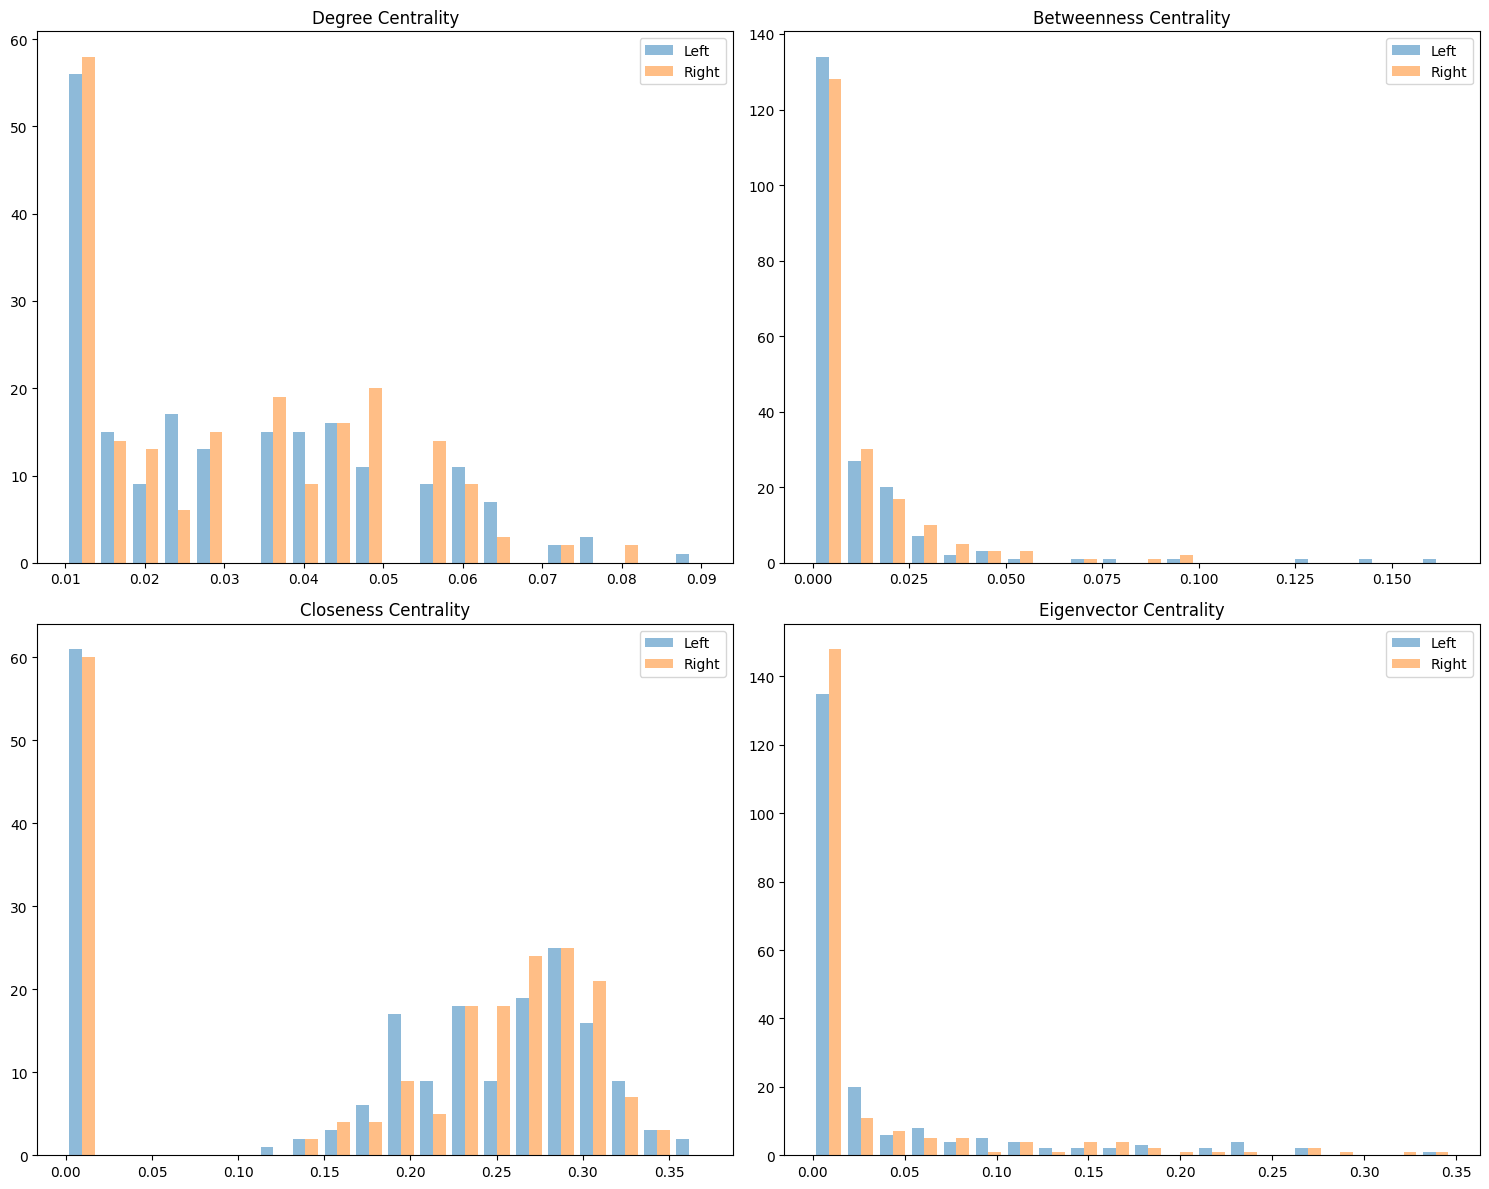

In [29]:
# hub analysis

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_hub_regions(matrix, threshold=0.5):
    """
    Identify and analyze hub regions in each hemisphere
    """
    n_regions = matrix.shape[0]
    mid_point = n_regions // 2
    
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[np.abs(matrix_thresh) <= threshold] = 0
    
    # Split into hemispheres
    left_matrix = matrix_thresh[:mid_point, :mid_point]
    right_matrix = matrix_thresh[mid_point:, mid_point:]
    
    # Create graphs
    G_left = nx.from_numpy_array(left_matrix)
    G_right = nx.from_numpy_array(right_matrix)
    
    def identify_hubs(G):
        # Calculate various centrality metrics
        degree_cent = nx.degree_centrality(G)
        betweenness_cent = nx.betweenness_centrality(G, weight='weight')
        closeness_cent = nx.closeness_centrality(G, distance='weight')
        eigenvector_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
        
        return {
            'degree': degree_cent,
            'betweenness': betweenness_cent,
            'closeness': closeness_cent,
            'eigenvector': eigenvector_cent
        }
    
    left_centrality = identify_hubs(G_left)
    right_centrality = identify_hubs(G_right)
    
    # Visualize centrality distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    metrics = ['degree', 'betweenness', 'closeness', 'eigenvector']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        # Convert dictionary values to lists
        left_values = list(left_centrality[metric].values())
        right_values = list(right_centrality[metric].values())
        
        ax.hist([left_values, right_values], label=['Left', 'Right'], 
                bins=20, alpha=0.5)
        ax.set_title(f'{metric.capitalize()} Centrality')
        ax.legend()
    
    plt.tight_layout()
    
    # Identify top hub regions
    def get_top_hubs(centrality_metrics, n=5):
        hubs = {}
        for metric in metrics:
            sorted_nodes = sorted(centrality_metrics[metric].items(),
                                key=lambda x: x[1], reverse=True)
            hubs[metric] = sorted_nodes[:n]
        return hubs
    
    left_hubs = get_top_hubs(left_centrality)
    right_hubs = get_top_hubs(right_centrality)
    
    # Print results
    print("\nTop Hub Regions:")
    for metric in metrics:
        print(f"\n{metric.capitalize()} Centrality:")
        print("\nLeft Hemisphere:")
        for node, value in left_hubs[metric]:
            print(f"Node {node}: {value:.3f}")
        print("\nRight Hemisphere:")
        for node, value in right_hubs[metric]:
            print(f"Node {node}: {value:.3f}")
    
    return {
        'left': left_centrality, 
        'right': right_centrality,
        'left_hubs': left_hubs,
        'right_hubs': right_hubs
    }

# Run analysis
hub_metrics = analyze_hub_regions(matrix, threshold=0.5)


Connection Analysis Summary:
Unique to Left Hemisphere: 708
Unique to Right Hemisphere: 700
Common Connections: 340

Connection Strength Differences (Left - Right):
Mean: -0.004
Std: 0.059
Max: 0.189
Min: -0.294


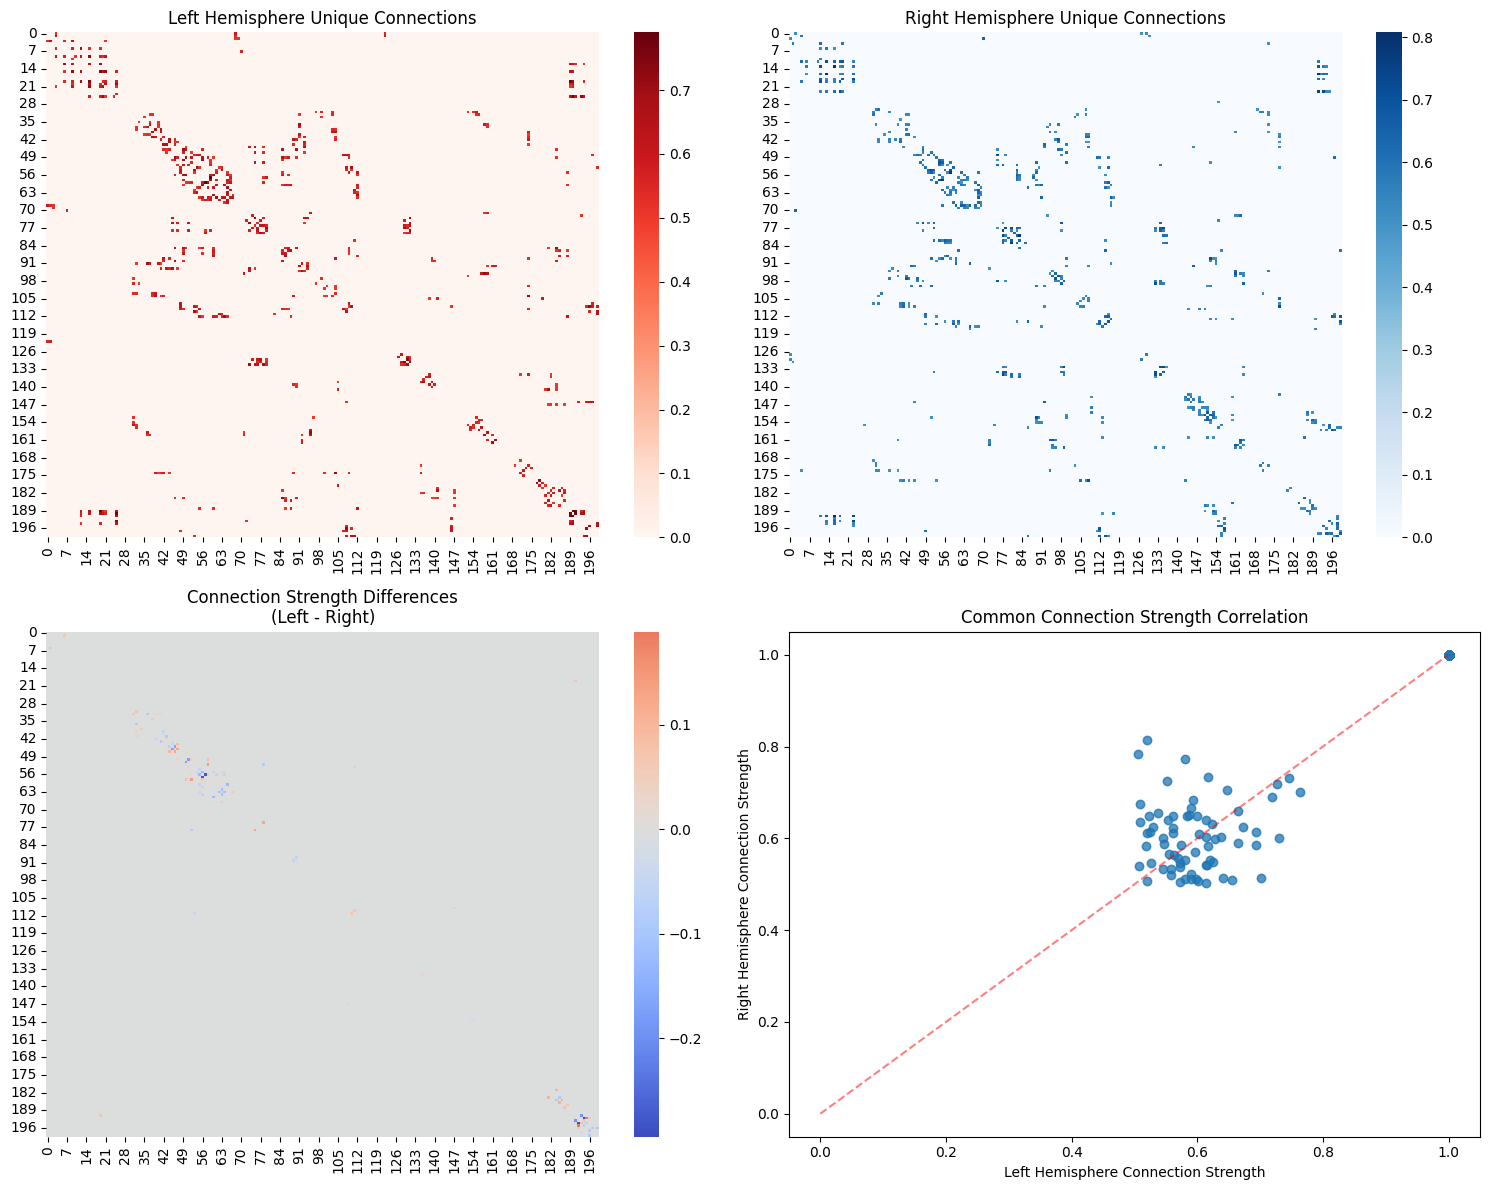

In [ ]:
# connection difference analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_connection_differences(matrix, threshold=0.5):
    """
    Analyze differences in connections between hemispheres
    """
    n_regions = matrix.shape[0]
    mid_point = n_regions // 2
    
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[np.abs(matrix_thresh) <= threshold] = 0
    
    # Split into hemispheres
    left_matrix = matrix_thresh[:mid_point, :mid_point]
    right_matrix = matrix_thresh[mid_point:, mid_point:]
    
    # Find unique connections in each hemisphere
    left_connections = set(map(tuple, np.argwhere(left_matrix != 0)))
    right_connections = set(map(tuple, np.argwhere(right_matrix != 0)))
    
    # Find differential connections
    left_unique = left_connections - right_connections
    right_unique = right_connections - left_connections
    common_connections = left_connections.intersection(right_connections)
    
    # Compare connection strengths for common connections
    strength_diff = np.zeros_like(left_matrix)
    for i, j in common_connections:
        strength_diff[i, j] = left_matrix[i, j] - right_matrix[i, j]
    
    # Visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot unique connections
    left_unique_mat = np.zeros_like(left_matrix)
    right_unique_mat = np.zeros_like(right_matrix)
    
    for i, j in left_unique:
        left_unique_mat[i, j] = left_matrix[i, j]
    for i, j in right_unique:
        right_unique_mat[i, j] = right_matrix[i, j]
    
    sns.heatmap(left_unique_mat, ax=ax1, cmap='Reds')
    ax1.set_title('Left Hemisphere Unique Connections')
    
    sns.heatmap(right_unique_mat, ax=ax2, cmap='Blues')
    ax2.set_title('Right Hemisphere Unique Connections')
    
    # Plot strength differences
    sns.heatmap(strength_diff, ax=ax3, cmap='coolwarm', center=0)
    ax3.set_title('Connection Strength Differences\n(Left - Right)')
    
    # Plot connection strength correlation
    common_left = []
    common_right = []
    for i, j in common_connections:
        common_left.append(left_matrix[i, j])
        common_right.append(right_matrix[i, j])
    
    ax4.scatter(common_left, common_right, alpha=0.5)
    ax4.set_xlabel('Left Hemisphere Connection Strength')
    ax4.set_ylabel('Right Hemisphere Connection Strength')
    ax4.set_title('Common Connection Strength Correlation')
    
    # Add diagonal line for reference
    max_val = max(max(common_left), max(common_right))
    ax4.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
    
    plt.tight_layout()
    
    # Print summary statistics
    print("\nConnection Analysis Summary:")
    print(f"Unique to Left Hemisphere: {len(left_unique)}")
    print(f"Unique to Right Hemisphere: {len(right_unique)}")
    print(f"Common Connections: {len(common_connections)}")
    
    # Analyze strength differences
    strength_diffs = [left_matrix[i, j] - right_matrix[i, j] for i, j in common_connections]
    print(f"\nConnection Strength Differences (Left - Right):")
    print(f"Mean: {np.mean(strength_diffs):.3f}")
    print(f"Std: {np.std(strength_diffs):.3f}")
    print(f"Max: {np.max(strength_diffs):.3f}")
    print(f"Min: {np.min(strength_diffs):.3f}")
    
    return {
        'left_unique': left_unique,
        'right_unique': right_unique,
        'common': common_connections,
        'strength_differences': strength_diffs
    }

# Run analysis
connection_diff = analyze_connection_differences(matrix, threshold=0.5)


Left Hemisphere Top Regions:

Top 5 regions by degree:
1. SomMot_26: 18.000
2. SomMot_19: 15.000
3. SomMot_25: 15.000
4. SomMot_30: 15.000
5. SomMot_35: 14.000

Top 5 regions by strength:
1. SomMot_26: 11.437
2. SomMot_19: 9.631
3. SomMot_30: 9.401
4. SomMot_25: 9.321
5. SomMot_35: 9.057

Top 5 regions by betweenness:
1. SalVentAttn_Med_4: 0.166
2. Default_PFC_10: 0.144
3. SalVentAttn_Med_3: 0.124
4. Default_pCunPCC_7: 0.093
5. SomMot_10: 0.080

Top 5 regions by eigenvector:
1. SomMot_26: 0.347
2. SomMot_30: 0.270
3. SomMot_19: 0.261
4. SomMot_35: 0.243
5. SomMot_28: 0.237

Right Hemisphere Top Regions:

Top 5 regions by degree:
1. SomMot_26: 16.000
2. SomMot_29: 16.000
3. SomMot_23: 14.000
4. SomMot_27: 14.000
5. SomMot_3: 13.000

Top 5 regions by strength:
1. SomMot_26: 10.593
2. SomMot_29: 10.173
3. SomMot_27: 9.338
4. Default_pCunPCC_1: 9.273
5. SomMot_23: 9.079

Top 5 regions by betweenness:
1. Default_PFCv_4: 0.093
2. Default_Temp_8: 0.092
3. SomMot_24: 0.089
4. Vis_5: 0.073
5. 

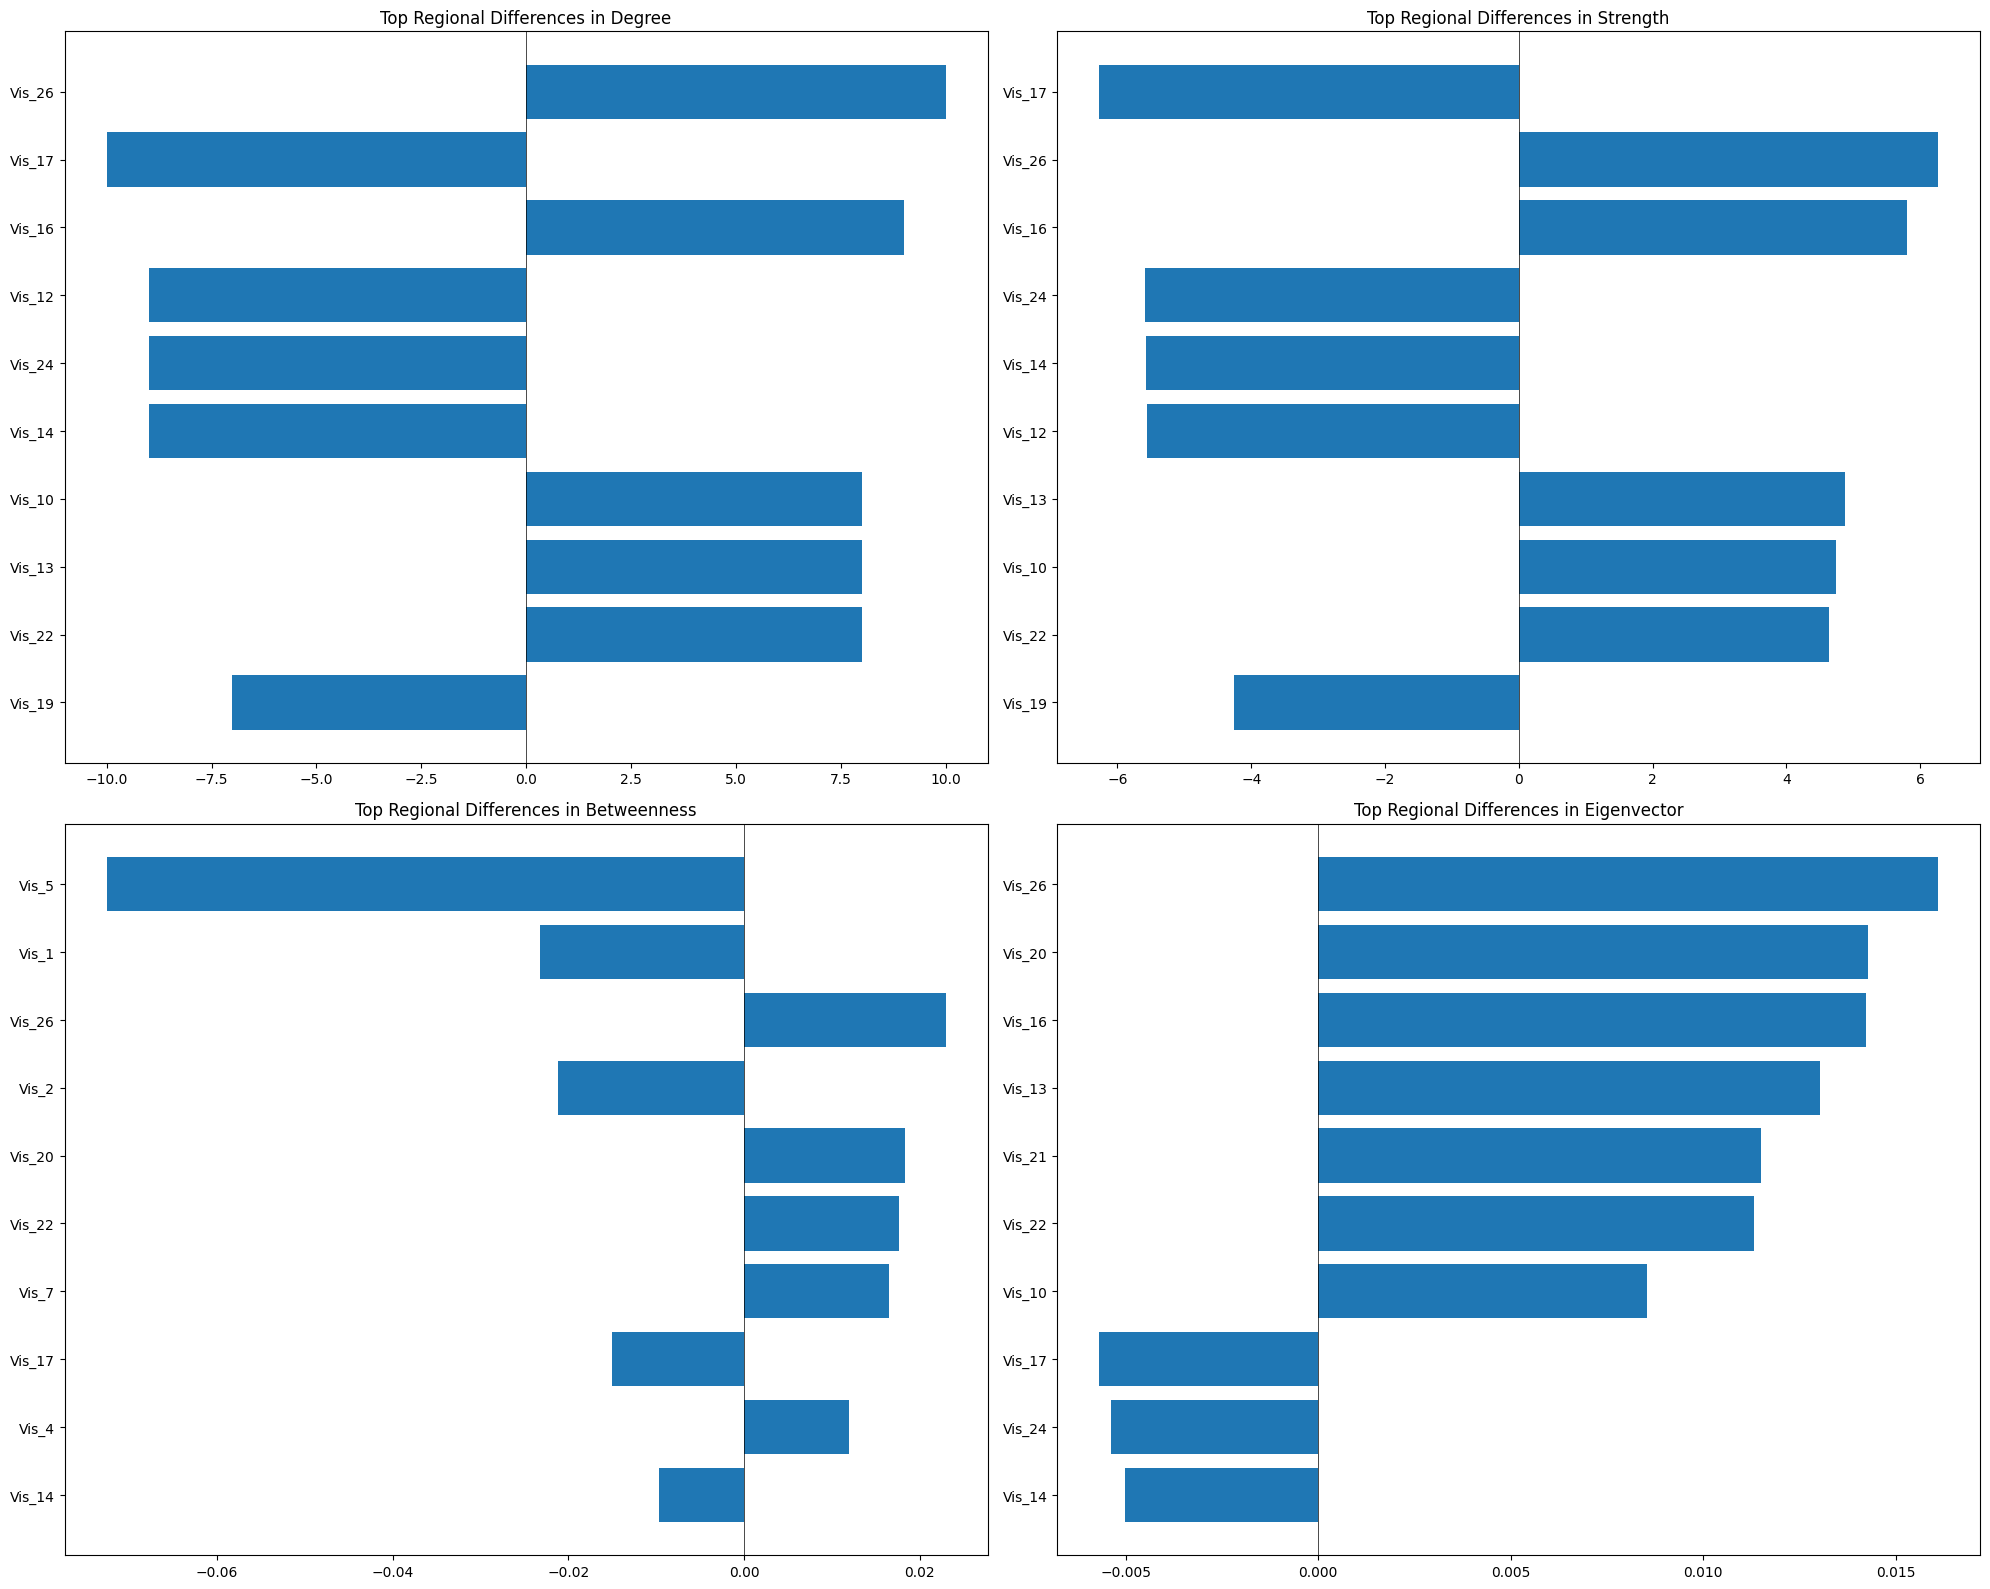

In [30]:
# plot to anatomical 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets

def map_to_anatomy(matrix, threshold=0.5):
    """
    Map network metrics to anatomical regions using Schaefer atlas
    """
    # Get Schaefer atlas labels
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7)
    labels = atlas.labels.astype('U')
    
    # Clean labels for easier reading
    clean_labels = []
    for label in labels:
        # Remove prefix and hemisphere indicator
        cleaned = label.split('7Networks_')[1] if '7Networks_' in label else label
        cleaned = cleaned.split('_')[1:] if '_' in cleaned else cleaned
        clean_labels.append('_'.join(cleaned))
    
    n_regions = matrix.shape[0]
    mid_point = n_regions // 2
    
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[np.abs(matrix_thresh) <= threshold] = 0
    
    # Split into hemispheres
    left_matrix = matrix_thresh[:mid_point, :mid_point]
    right_matrix = matrix_thresh[mid_point:, mid_point:]
    
    # Create graphs
    G_left = nx.from_numpy_array(left_matrix)
    G_right = nx.from_numpy_array(right_matrix)
    
    # Calculate metrics for each node
    def get_node_metrics(G):
        metrics = {
            'degree': dict(G.degree()),
            'strength': dict(nx.degree(G, weight='weight')),
            'betweenness': nx.betweenness_centrality(G, weight='weight'),
            'eigenvector': nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
        }
        return metrics
    
    left_metrics = get_node_metrics(G_left)
    right_metrics = get_node_metrics(G_right)
    
    # Create summary dataframe-like structure
    left_summary = []
    right_summary = []
    
    # Get top nodes for each metric
    for i in range(mid_point):
        left_data = {
            'node': i,
            'region': clean_labels[i],
            'degree': left_metrics['degree'][i],
            'strength': left_metrics['strength'][i],
            'betweenness': left_metrics['betweenness'][i],
            'eigenvector': left_metrics['eigenvector'][i]
        }
        left_summary.append(left_data)
        
        right_data = {
            'node': i,
            'region': clean_labels[i + mid_point],
            'degree': right_metrics['degree'][i],
            'strength': right_metrics['strength'][i],
            'betweenness': right_metrics['betweenness'][i],
            'eigenvector': right_metrics['eigenvector'][i]
        }
        right_summary.append(right_data)
    
    # Print top regions by different metrics
    def print_top_regions(summary, hemisphere, n=5):
        print(f"\n{hemisphere} Hemisphere Top Regions:")
        
        metrics = ['degree', 'strength', 'betweenness', 'eigenvector']
        for metric in metrics:
            sorted_regions = sorted(summary, key=lambda x: x[metric], reverse=True)[:n]
            print(f"\nTop {n} regions by {metric}:")
            for idx, region in enumerate(sorted_regions, 1):
                print(f"{idx}. {region['region']}: {region[metric]:.3f}")
    
    print_top_regions(left_summary, "Left")
    print_top_regions(right_summary, "Right")
    
    # Plot regional differences
    def plot_regional_differences(left_summary, right_summary):
        metrics = ['degree', 'strength', 'betweenness', 'eigenvector']
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx//2, idx%2]
            
            # Calculate differences
            differences = []
            regions = []
            for l, r in zip(left_summary, right_summary):
                if l['region'] == r['region']:  # matching regions
                    differences.append(l[metric] - r[metric])
                    regions.append(l['region'])
            
            # Sort by absolute difference
            sorted_idx = np.argsort(np.abs(differences))[-10:]  # top 10 differences
            
            # Plot
            ax.barh([regions[i] for i in sorted_idx], 
                   [differences[i] for i in sorted_idx])
            ax.set_title(f'Top Regional Differences in {metric.capitalize()}')
            ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
            
        plt.tight_layout()
        return fig
    
    plot_regional_differences(left_summary, right_summary)
    
    return left_summary, right_summary

# Run analysis
left_summary, right_summary = map_to_anatomy(matrix, threshold=0.5)


Ventral-Dorsal Pathway Analysis:

Left Hemisphere:
Ventral pathway connectivity: 0.243
Dorsal pathway connectivity: 0.322
Between pathway connectivity: 0.229
Number of ventral nodes: 65
Number of dorsal nodes: 60

Right Hemisphere:
Ventral pathway connectivity: 0.233
Dorsal pathway connectivity: 0.297
Between pathway connectivity: 0.217
Number of ventral nodes: 59
Number of dorsal nodes: 63


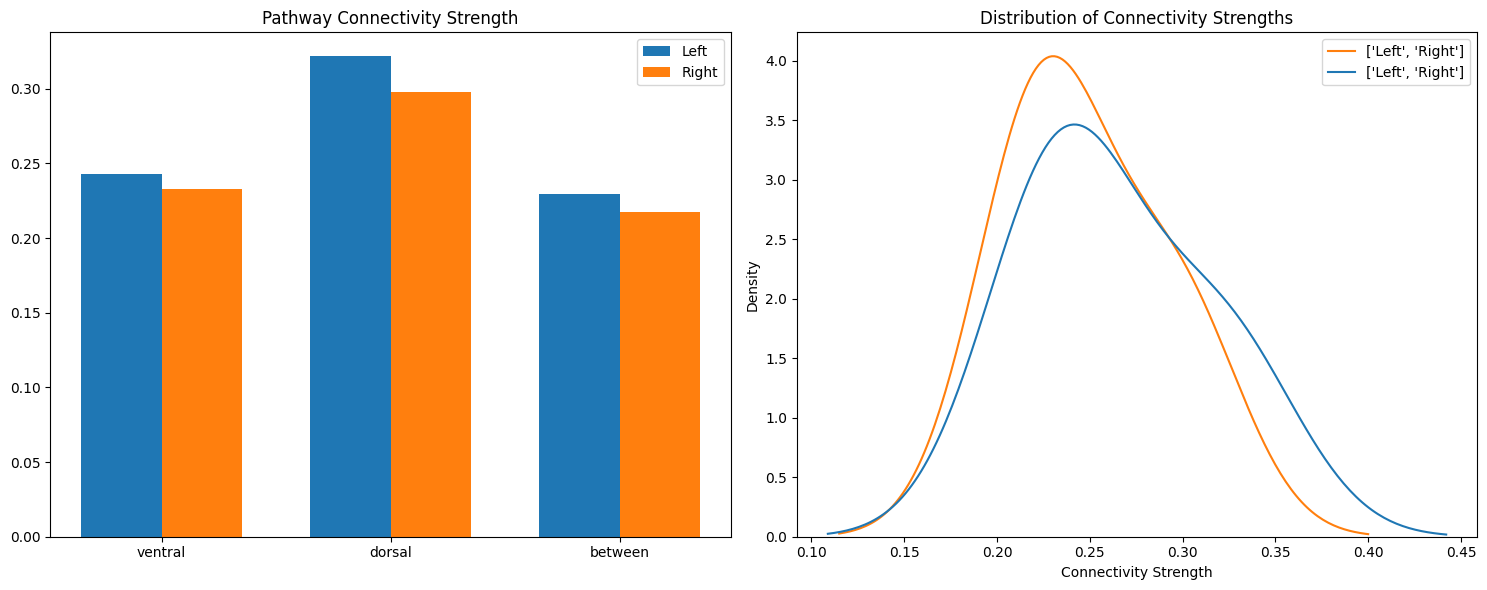

In [33]:
# dorsal v ventral on hemispheres

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets

def analyze_ventral_dorsal(matrix, threshold=0.5):
    """
    Analyze ventral vs dorsal pathway connectivity in each hemisphere
    """
    # Get Schaefer atlas labels
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7)
    labels = atlas.labels.astype('U')
    
    # Define ventral and dorsal networks
    ventral_keywords = ['SalVentAttn', 'Default_PFC', 'Temp', 'Vis_Temp']
    dorsal_keywords = ['DorsAttn', 'SomMot', 'Vis_Dors']
    
    # Classify regions
    def classify_pathway(label):
        if any(kw in label for kw in ventral_keywords):
            return 'ventral'
        elif any(kw in label for kw in dorsal_keywords):
            return 'dorsal'
        else:
            return 'other'
    
    pathways = [classify_pathway(label) for label in labels]
    
    # Split matrix by hemisphere
    n_regions = len(labels) // 2
    left_matrix = matrix[:n_regions, :n_regions]
    right_matrix = matrix[n_regions:, n_regions:]
    
    def get_pathway_connectivity(mat, pathways, start_idx=0):
        ventral_idx = [i for i, p in enumerate(pathways[start_idx:start_idx+n_regions]) 
                      if p == 'ventral']
        dorsal_idx = [i for i, p in enumerate(pathways[start_idx:start_idx+n_regions]) 
                     if p == 'dorsal']
        
        # Calculate within and between pathway connectivity
        ventral_connectivity = np.mean(mat[np.ix_(ventral_idx, ventral_idx)])
        dorsal_connectivity = np.mean(mat[np.ix_(dorsal_idx, dorsal_idx)])
        between_connectivity = np.mean(mat[np.ix_(ventral_idx, dorsal_idx)])
        
        return {
            'ventral': ventral_connectivity,
            'dorsal': dorsal_connectivity,
            'between': between_connectivity,
            'ventral_nodes': len(ventral_idx),
            'dorsal_nodes': len(dorsal_idx)
        }
    
    left_connectivity = get_pathway_connectivity(left_matrix, pathways)
    right_connectivity = get_pathway_connectivity(right_matrix, pathways, n_regions)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Connectivity strengths
    metrics = ['ventral', 'dorsal', 'between']
    left_values = [left_connectivity[m] for m in metrics]
    right_values = [right_connectivity[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax1.bar(x - width/2, left_values, width, label='Left')
    ax1.bar(x + width/2, right_values, width, label='Right')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics)
    ax1.set_title('Pathway Connectivity Strength')
    ax1.legend()
    
    # Plot 2: Mean connectivity distribution
    ventral_left = np.mean(left_matrix[np.tril_indices(n_regions, k=-1)])
    ventral_right = np.mean(right_matrix[np.tril_indices(n_regions, k=-1)])
    
    sns.kdeplot(data=[left_values, right_values], ax=ax2, label=['Left', 'Right'])
    ax2.set_title('Distribution of Connectivity Strengths')
    ax2.set_xlabel('Connectivity Strength')
    ax2.set_ylabel('Density')
    ax2.legend()
    
    plt.tight_layout()
    
    # Print analysis results
    print("\nVentral-Dorsal Pathway Analysis:")
    print("\nLeft Hemisphere:")
    print(f"Ventral pathway connectivity: {left_connectivity['ventral']:.3f}")
    print(f"Dorsal pathway connectivity: {left_connectivity['dorsal']:.3f}")
    print(f"Between pathway connectivity: {left_connectivity['between']:.3f}")
    print(f"Number of ventral nodes: {left_connectivity['ventral_nodes']}")
    print(f"Number of dorsal nodes: {left_connectivity['dorsal_nodes']}")
    
    print("\nRight Hemisphere:")
    print(f"Ventral pathway connectivity: {right_connectivity['ventral']:.3f}")
    print(f"Dorsal pathway connectivity: {right_connectivity['dorsal']:.3f}")
    print(f"Between pathway connectivity: {right_connectivity['between']:.3f}")
    print(f"Number of ventral nodes: {right_connectivity['ventral_nodes']}")
    print(f"Number of dorsal nodes: {right_connectivity['dorsal_nodes']}")
    
    return left_connectivity, right_connectivity

# Run analysis
left_path, right_path = analyze_ventral_dorsal(matrix, threshold=0.5)

In [ ]:
# new file for topology and geometry analysis and visualization

Compare this to known object recognition pathways?
